## **1.** **Environment Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

print("Done!")

Done!


## **2.** **Data Preprocessing and Integration**

In [2]:
# This function converts the volume data from "10.0K" to 10000.0
def convert_volume(x):
  if isinstance(x, str):
    x = x.upper().replace(",", "") # removes commas
    if "K" in x:
      return float(x.replace("K", "")) * 1000
    elif "M" in x:
      return float(x.replace("M", "")) * 1000000
    elif "B" in x:
      return float(x.replace("B", "")) * 1000000000
    elif x == "-": # if the volume is missing
      return np.nan
  return float(x)

def convert_change(x):
  if isinstance(x, str):
    x = x.replace("%", "")
  return float(x) / 100

# merging and cleaning function
def load_investing_data(filename):
  df = pd.read_csv(filename)

  # converts date data
  df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
  df = df.set_index("Date").sort_index()

  # remove the commas in the columns
  cols_to_fix = ["Price", "Open", "High", "Low"]
  for col in cols_to_fix:
    if col in df.columns and df[col].dtype == "object":
      df[col] = df[col].str.replace(",", "").astype(float)

  # handle the Volume
  if "Vol." in df.columns:
    df["Vol."] = df["Vol."].apply(convert_volume)

  # handle the Change
  if "Change %" in df.columns:
    df["Change %"] = df["Change %"].apply(convert_change)

  return df[["Price", "Open", "High", "Low", "Vol.", "Change %"]]


print("Loading files:")
df_BIST = load_investing_data("BIST100_data.csv")
df_CSI = load_investing_data("CSI300_data.csv")

df_combined = pd.merge(df_BIST, df_CSI, left_index=True, right_index=True, how="inner", suffixes=("_BIST", "_CSI"))


print(f"Done! Final dataset shape: {df_combined.shape}")
print(f"Columns: {df_combined.columns.to_list()}")
print(df_combined.head())

Loading files:
Done! Final dataset shape: (2349, 12)
Columns: ['Price_BIST', 'Open_BIST', 'High_BIST', 'Low_BIST', 'Vol._BIST', 'Change %_BIST', 'Price_CSI', 'Open_CSI', 'High_CSI', 'Low_CSI', 'Vol._CSI', 'Change %_CSI']
            Price_BIST  Open_BIST  High_BIST  Low_BIST    Vol._BIST  \
Date                                                                  
2015-01-05      864.63     854.95     867.96    854.11  644590000.0   
2015-01-06      869.10     866.51     869.12    855.75  698320000.0   
2015-01-07      867.77     869.25     876.26    864.98  791950000.0   
2015-01-08      876.90     874.05     879.19    872.60  731760000.0   
2015-01-09      876.48     877.46     883.27    874.28  711730000.0   

            Change %_BIST  Price_CSI  Open_CSI  High_CSI  Low_CSI  Vol._CSI  \
Date                                                                          
2015-01-05         0.0117    3641.54   3566.09   3669.04  3551.51  451200.0   
2015-01-06         0.0052    3641.06   3608.

In [3]:
df_combined['CSI_change_lag1'] = df_combined['Change %_CSI'].shift(1)

df_combined['is_covid'] = ((df_combined.index >= '2020-01-01') & (df_combined.index <= '2021-12-31')).astype(int)
df_combined['is_post_covid'] = (df_combined.index > '2021-12-31').astype(int)

df_combined = df_combined.dropna()

X = df_combined[['Change %_CSI', 'CSI_change_lag1', 'is_covid', 'is_post_covid']]
y = df_combined['Change %_BIST']

split_idx = int(len(df_combined) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Data successfully prepared using existing 'Change %' columns.")
print(f"Features included: {X.columns.to_list()}")

Data successfully prepared using existing 'Change %' columns.
Features included: ['Change %_CSI', 'CSI_change_lag1', 'is_covid', 'is_post_covid']


In [5]:
cols_to_analyze = ["Change %_BIST", "Change %_CSI"]

stats_summary = df_combined[cols_to_analyze].agg(["mean", "median", "std", "skew", "kurtosis"])

stats_summary.columns = ["BIST100", "CSI300"]

stats_formatted = stats_summary.copy()
stats_formatted.loc[["mean", "median", "std"]] *= 100

print("--- Statistics for Daily Returns ---")
print(stats_formatted.round(4))

--- Statistics for Daily Returns ---
          BIST100  CSI300
mean       0.1038  0.0123
median     0.1500  0.0200
std        1.5710  1.4074
skew      -0.5542 -0.5761
kurtosis   4.5494  6.2293


## **3.** **Applying Machine Learning Methods**

--- Baseline Model Performance ---
RMSE: 0.01973
R2 Score: -0.03071
----------------------------------
Model Intercept (Pre-Covid Baseline): 0.00027

Feature Coefficients:
                 Coefficient
Change %_CSI        0.105309
CSI_change_lag1    -0.005422
is_covid            0.000948
is_post_covid       0.003770


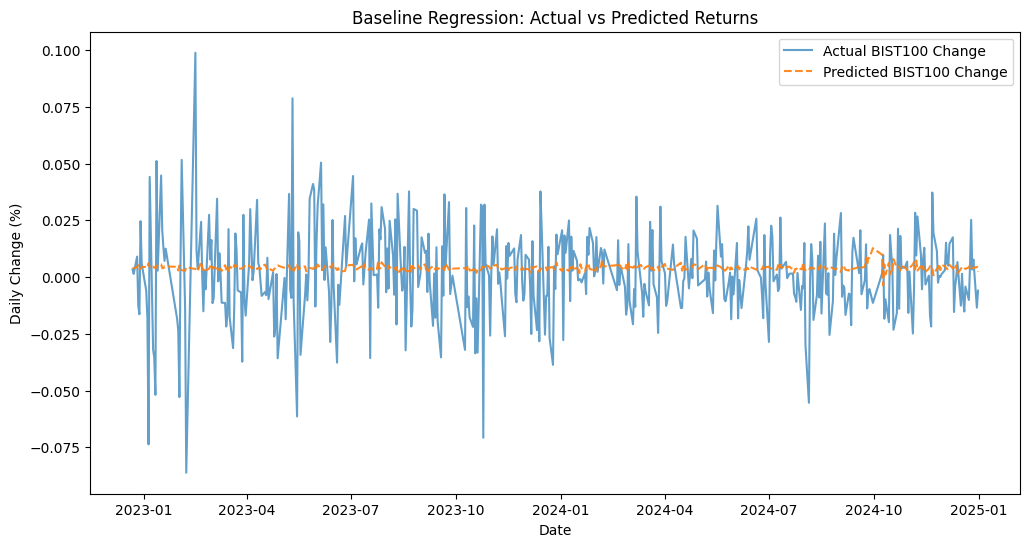

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print("--- Baseline Model Performance ---")
print(f"RMSE: {rmse:.5f}")
print(f"R2 Score: {r2:.5f}")
print("-" * 34)

coefficients = pd.DataFrame(baseline_model.coef_, X.columns, columns=['Coefficient'])
intercept = baseline_model.intercept_

print(f"Model Intercept (Pre-Covid Baseline): {intercept:.5f}")
print("\nFeature Coefficients:")
print(coefficients)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual BIST100 Change', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted BIST100 Change', alpha=0.9, linestyle='--')
plt.title("Baseline Regression: Actual vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Daily Change (%)")
plt.legend()
plt.show()

**Interpretation:**

The Baseline Multiple Linear Regression model demonstrates significant underfitting, with a negative R² of -0.03071 and an RMSE of 0.01973, suggesting poor explanatory power in predicting BIST100 daily returns. The model's performance is akin to a simple average, as it primarily captures the mean return rather than daily fluctuations, likely due to the complex, non-linear nature of financial markets. The coefficient for the Change %_CSI (0.1053) indicates a weak positive correlation, but its impact is economically negligible. Additionally, the Covid and post-Covid dummy variables show minor positive coefficients, indicating only slight shifts in average returns, rather than any significant structural changes. Overall, these results highlight a weak relationship between CSI300 returns, pandemic-related variables, and BIST100 daily returns, reinforcing the limited predictive value of these factors.

--- Random Forest Model Performance ---
RMSE: 0.02098
R2 Score: -0.16547
---------------------------------------
Feature Importances:
                 Importance
CSI_change_lag1    0.470804
Change %_CSI       0.455959
is_covid           0.044444
is_post_covid      0.028792


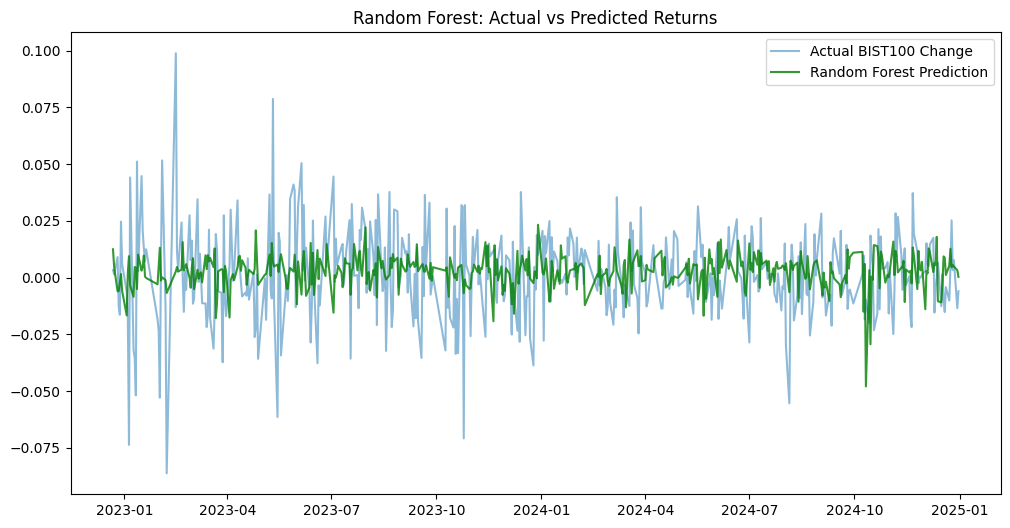

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Model Performance ---")
print(f"RMSE: {rmse_rf:.5f}")
print(f"R2 Score: {r2_rf:.5f}")
print("-" * 39)

importances = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

print("Feature Importances:")
print(importances)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual BIST100 Change', alpha=0.5)
plt.plot(y_test.index, y_pred_rf, label='Random Forest Prediction', color='green', alpha=0.8)
plt.title("Random Forest: Actual vs Predicted Returns")
plt.legend()
plt.show()

**Interpretation:**

The Random Forest model fails to improve predictive performance compared to the linear baseline, with a more negative R² of -0.16547 and an increased RMSE of 0.02098, indicating overfitting and high variance. Although the model assigns significant importance to both current and past CSI300 returns (over 92% of feature importance), it fails to capture the large fluctuations in BIST100 returns, producing a smooth predicted series. COVID and post-COVID indicators have little effect, suggesting that these periods did not create a clear predictive pattern. Overall, the results highlight the weak and unpredictable relationship between the Turkish and Chinese stock markets, with non-linear models offering little improvement in forecasting performance.


--- Logistic Regression Classification Results ---
Accuracy Score: 0.5170

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       226
           1       0.52      1.00      0.68       244

    accuracy                           0.52       470
   macro avg       0.26      0.50      0.34       470
weighted avg       0.27      0.52      0.35       470



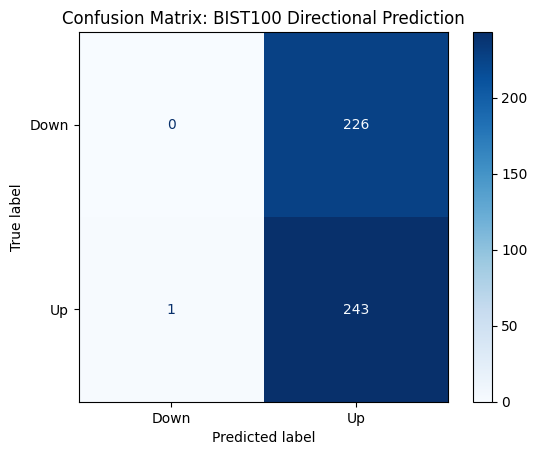

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train_class)

y_pred_class = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

print("--- Logistic Regression Classification Results ---")
print(f"Accuracy Score: {accuracy_score(y_test_class, y_pred_class):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: BIST100 Directional Prediction")
plt.show()

**Interpretation:**

The logistic regression model exhibits no meaningful ability to predict the direction of BIST100 returns, achieving an accuracy of 51.7%, which is only marginally above random guessing. The confusion matrix reveals a severe majority class bias, as the model consistently predicts an “Up” market and fails to identify any “Down” days, reflected in zero precision and recall for the negative class. This apparent accuracy merely mirrors the dominant frequency of upward movements in the data rather than genuine predictive power. Overall, the results indicate that CSI300-related variables and the linear feature set provide no useful information for forecasting the short-term direction of BIST100 returns, resulting in a high-bias model unable to distinguish between market regimes.


--- Random Forest Classifier (Balanced) Results ---
Accuracy Score: 0.5298

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.05      0.09       226
           1       0.53      0.98      0.68       244

    accuracy                           0.53       470
   macro avg       0.59      0.51      0.39       470
weighted avg       0.58      0.53      0.40       470



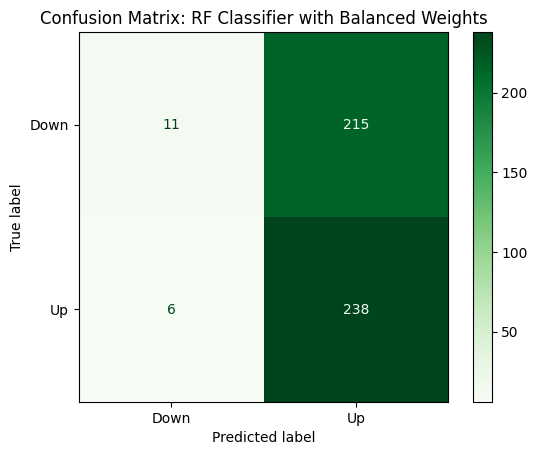


Feature Importances for Classification:
                 Importance
Change %_CSI       0.457845
CSI_change_lag1    0.392830
is_post_covid      0.090998
is_covid           0.058328


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

rf_class_model = RandomForestClassifier(n_estimators=200, max_depth=5, class_weight='balanced', random_state=42)

rf_class_model.fit(X_train_scaled, y_train_class)

y_pred_rf_class = rf_class_model.predict(X_test_scaled)

print("--- Random Forest Classifier (Balanced) Results ---")
print(f"Accuracy Score: {accuracy_score(y_test_class, y_pred_rf_class):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_rf_class))

cm_rf = confusion_matrix(y_test_class, y_pred_rf_class)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Down', 'Up'])
disp_rf.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix: RF Classifier with Balanced Weights")
plt.show()

importances = pd.DataFrame(rf_class_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("\nFeature Importances for Classification:")
print(importances)

**Interpretation:**

The balanced Random Forest classifier shows only a slight improvement over the logistic regression model, achieving an accuracy of 52.98%, which is still close to random classification. Although class balancing enhances the model's ability to detect market declines, recall for the negative class remains very low, highlighting the model’s difficulty in accurately identifying down days. Feature importance analysis reveals that current and lagged CSI300 returns dominate the model's decision-making, but this information does not lead to reliable directional predictions for BIST100. Overall, the findings suggest that even after addressing class imbalance and incorporating non-linearity, CSI300-based features offer limited explanatory power for forecasting the direction of the Turkish stock market.


--- ADF Test for BIST100 Returns ---
ADF Statistic: -12.0005
p-value: 0.0000
Result: Stationary (Good for ML) 

--- Final Model Results ---
Accuracy: 0.5203

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.04      0.07       226
           1       0.52      0.97      0.68       243

    accuracy                           0.52       469
   macro avg       0.52      0.50      0.38       469
weighted avg       0.52      0.52      0.39       469



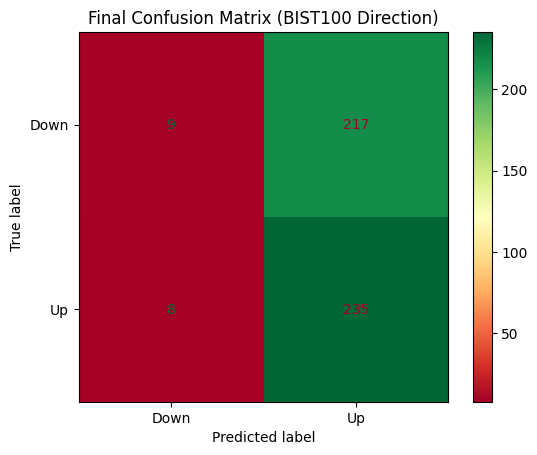


Final Feature Importances:
                   Importance
Change %_CSI         0.259517
CSI_volatility_7d    0.225910
CSI_change_lag1      0.206032
CSI_momentum_3d      0.203219
is_post_covid        0.067646
is_covid             0.037675


In [9]:
from statsmodels.tsa.stattools import adfuller

df_combined['CSI_volatility_7d'] = df_combined['Change %_CSI'].rolling(window=7).std()

df_combined['CSI_momentum_3d'] = df_combined['Change %_CSI'].rolling(window=3).mean()

df_combined['CSI_change_lag1'] = df_combined['Change %_CSI'].shift(1)

df_final = df_combined.dropna().copy()

def check_stationarity(series, name):
    result = adfuller(series)
    print(f"--- ADF Test for {name} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Result: Stationary (Good for ML) \n")
    else:
        print("Result: Non-Stationary (Trend detected) \n")

check_stationarity(df_final['Change %_BIST'], "BIST100 Returns")

X = df_final[['Change %_CSI', 'CSI_change_lag1', 'is_covid', 'is_post_covid', 'CSI_volatility_7d', 'CSI_momentum_3d']]
y_class = (df_final['Change %_BIST'] > 0).astype(int)

split_idx = int(len(df_final) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_class, y_test_class = y_class.iloc[:split_idx], y_class.iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_model = RandomForestClassifier(n_estimators=250, max_depth=5, class_weight='balanced_subsample', random_state=42)
final_model.fit(X_train_scaled, y_train_class)

y_pred = final_model.predict(X_test_scaled)

print("--- Final Model Results ---")
print(f"Accuracy: {accuracy_score(y_test_class, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred))

cm = confusion_matrix(y_test_class, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap=plt.cm.RdYlGn)
plt.title("Final Confusion Matrix (BIST100 Direction)")
plt.show()

importances = pd.DataFrame(final_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
print("\nFinal Feature Importances:")
print(importances)

**Interpretation:**

The final enhanced Random Forest model, which incorporates a broader set of features such as market volatility and momentum, shows limited predictive performance with an accuracy of only 52.0%. The Augmented Dickey-Fuller (ADF) test confirms that BIST100 daily returns are stationary, making the data suitable for machine learning and time-series modeling. Despite this, the classifier remains heavily biased toward predicting positive return days, with very low recall for negative movements. Feature importance analysis reveals that CSI300 returns, volatility, and short-term momentum are the primary drivers of the model's decisions, while COVID-related indicators play a minor role. Overall, even with stationary data and expanded feature engineering, the results suggest that Chinese market dynamics provide weak and unreliable signals for predicting the direction of BIST100 returns.


--- Granger Causality Test: Does China lead Turkey? ---

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5562  , p=0.4559  , df_denom=2337, df_num=1
ssr based chi2 test:   chi2=0.5569  , p=0.4555  , df=1
likelihood ratio test: chi2=0.5568  , p=0.4555  , df=1
parameter F test:         F=0.5562  , p=0.4559  , df_denom=2337, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3990  , p=0.6711  , df_denom=2334, df_num=2
ssr based chi2 test:   chi2=0.7996  , p=0.6704  , df=2
likelihood ratio test: chi2=0.7995  , p=0.6705  , df=2
parameter F test:         F=0.3990  , p=0.6711  , df_denom=2334, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4031  , p=0.7508  , df_denom=2331, df_num=3
ssr based chi2 test:   chi2=1.2128  , p=0.7499  , df=3
likelihood ratio test: chi2=1.2125  , p=0.7500  , df=3
parameter F test:         F=0.4031  , p=0.7508  , df_denom=2331, df_num=3


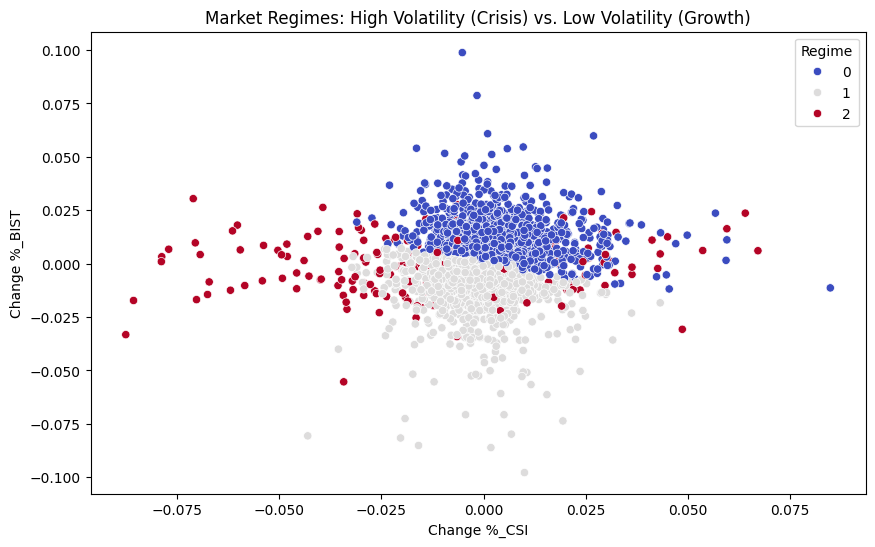

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.cluster import KMeans

print("--- Granger Causality Test: Does China lead Turkey? ---")

gc_data = df_final[['Change %_BIST', 'Change %_CSI']]
grangercausalitytests(gc_data, maxlag=3)

cluster_features = df_final[['Change %_BIST', 'Change %_CSI', 'CSI_volatility_7d']]
cluster_scaled = StandardScaler().fit_transform(cluster_features)

km = KMeans(n_clusters=3, random_state=42).fit(cluster_scaled)
df_final['Regime'] = km.labels_

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_final, x='Change %_CSI', y='Change %_BIST', hue='Regime', palette='coolwarm')
plt.title("Market Regimes: High Volatility (Crisis) vs. Low Volatility (Growth)")
plt.show()

**Interpretation:**

The Granger causality tests reveal no significant evidence that movements in the Chinese stock market (CSI300) predict returns in the Turkish stock market (BIST100). Across all tested lag lengths (1 to 3 days), the p-values are well above the conventional significance threshold, ranging from 0.4559 to 0.7508, leading to a failure to reject the null hypothesis. This indicates that past CSI300 returns do not provide additional predictive information for future BIST100 returns. These findings align with earlier regression and machine learning results, supporting the conclusion that short-term lead-lag relationships between the Chinese and Turkish equity markets are either weak or non-existent. The results suggest that the two markets likely respond to shared global shocks or independent local factors, such as Turkey's inflationary trends, rather than a direct causal influence from China.


In [12]:
regime_profile = df_final.groupby('Regime')[['Change %_BIST', 'Change %_CSI', 'CSI_volatility_7d']].mean()
print("--- Market Regime Profiles ---")
print(regime_profile)

--- Market Regime Profiles ---
        Change %_BIST  Change %_CSI  CSI_volatility_7d
Regime                                                
0            0.011795      0.004071           0.010234
1           -0.010404     -0.001954           0.009525
2           -0.000627     -0.008958           0.028525


**Interpretation:**

The K-Means clustering analysis identifies three distinct market regimes based on returns and volatility:


*   **Regime 0 (Bull/Growth Regime)**: Characterized by high positive BIST100 returns (1.18%) and low volatility, this regime likely reflects stable recovery phases, often driven by Turkey's inflationary trends.
*   **Regime 1 (Local Bear/Correction)**: Marked by a significant drop in the Turkish market (-1.04%) while China remains stable, suggesting periods influenced by local economic factors in Turkey, independent of international market movements.
*   **Regime 2 (Crisis/Panic Regime)**: Defined by high volatility (2.85%) and sharp declines in the Chinese market (-0.90%), capturing major global disruptions like the initial COVID-19 shock.

These distinct market moods explain the low R² scores observed in earlier models, indicating that the relationship between the Turkish and Chinese markets changes significantly depending on global economic conditions. In particular, stress in the Chinese market does not necessarily lead to sharp declines in the Turkish market, showing limited spillover effects between the two markets.

